# Anomaly Detection with Fastestimator

In this notebook we will demonstrate how to do anomaly detection using one class classifier as described in [Adversarially Learned One-Class Classifier for Novelty Detection](https://arxiv.org/pdf/1802.09088.pdf). In real world, outliers or novelty class is often absent from the training dataset. Such problems can be efficiently modeled using one class classifiers.
In the algorihm demonstrated below, two networks are trained to compete with each other where one network acts as a novelty detector and other enhaces the inliers and distorts the outliers. We use images of digit "1" from MNIST dataset for training and images of other digits as outliers.

In [1]:
import tempfile

import fastestimator as fe
import numpy as np
import tensorflow as tf
from fastestimator.backend import binary_crossentropy
from fastestimator.op.numpyop import LambdaOp
from fastestimator.op.numpyop.univariate import ExpandDims, Normalize
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace import Trace
from fastestimator.trace.io import BestModelSaver
from fastestimator.util import to_number
from sklearn.metrics import auc, f1_score, roc_curve
from tensorflow.python.keras import layers

In [2]:
# Parameters
epochs=20
batch_size=128
train_steps_per_epoch=None
save_dir=tempfile.mkdtemp()

## Building Components

### Downloading the data

First, we will download training images using tensorflow API. We will use images of digit `1` for training and test images of `1` as inliers and images of other digits as outliers. Outliers comprise 50% of our validation dataset.

In [3]:
(x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.mnist.load_data()

# Create Training Dataset
x_train, y_train = x_train[np.where((y_train == 1))], np.zeros(y_train[np.where((y_train == 1))].shape)
train_data = fe.dataset.NumpyDataset({"x": x_train, "y": y_train})

# Create Validation Dataset
x_eval0, y_eval0 = x_eval[np.where((y_eval == 1))], np.ones(y_eval[np.where((y_eval == 1))].shape)
x_eval1, y_eval1 = x_eval[np.where((y_eval != 1))], y_eval[np.where((y_eval != 1))]

# Ensuring outliers comprise 50% of the dataset
index = np.random.choice(x_eval1.shape[0], int(x_eval0.shape[0]), replace=False)
x_eval1, y_eval1 = x_eval1[index], np.zeros(y_eval1[index].shape)

x_eval, y_eval = np.concatenate([x_eval0, x_eval1]), np.concatenate([y_eval0, y_eval1])
eval_data = fe.dataset.NumpyDataset({"x": x_eval, "y": y_eval})

### Step 1: Create `Pipeline`

We will use the `LambdaOp` to add noise to the images during training.

In [4]:
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size,
    ops=[
        ExpandDims(inputs="x", outputs="x"),
        Normalize(inputs="x", outputs="x", mean=1.0, std=1.0, max_pixel_value=127.5),
        LambdaOp(fn=lambda x: x + np.random.normal(loc=0.0, scale=0.155, size=(28, 28, 1)),
                 inputs="x",
                 outputs="x_w_noise",
                 mode="train")
    ])

We can visualize sample images from our `Pipeline` using the 'get_results' method.

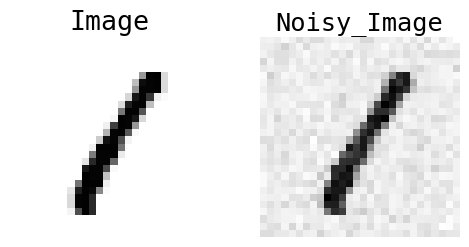

In [5]:
sample_batch = pipeline.get_results()

img = fe.util.ImgData(Image=sample_batch["x"][0].numpy().reshape(1, 28, 28, 1), 
                      Noisy_Image=sample_batch["x_w_noise"][0].numpy().reshape(1, 28, 28, 1))
fig = img.paint_figure()

### Step 2: Create `Network`

The architecture of our model consists of an Autoencoder (ecoder-decoder) network and a Discriminator network.
![Network Architecture](./network_architecture.PNG)[Credit: https://arxiv.org/pdf/1802.09088.pdf]

In [6]:
def reconstructor(input_shape=(28, 28, 1)):
    model = tf.keras.Sequential()
    # Encoder Block
    model.add(
        layers.Conv2D(32, (5, 5),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                      input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(
        layers.Conv2D(64, (5, 5),
                      strides=(2, 2),
                      kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                      padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(
        layers.Conv2D(128, (5, 5),
                      strides=(2, 2),
                      kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                      padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Decoder Block
    model.add(
        layers.Conv2DTranspose(32, (5, 5),
                               strides=(2, 2),
                               output_padding=(0, 0),
                               padding='same',
                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(
        layers.Conv2DTranspose(16, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(
        layers.Conv2DTranspose(1, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                               activation='tanh'))
    return model


def discriminator(input_shape=(28, 28, 1)):
    model = tf.keras.Sequential()
    model.add(
        layers.Conv2D(16, (5, 5),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                      input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(
        layers.Conv2D(32, (5, 5),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(
        layers.Conv2D(64, (5, 5),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(
        layers.Conv2D(128, (5, 5),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [7]:
recon_model = fe.build(model_fn=reconstructor, optimizer_fn=lambda: tf.optimizers.RMSprop(2e-4), model_name="reconstructor")
disc_model = fe.build(model_fn=discriminator,
                      optimizer_fn=lambda: tf.optimizers.RMSprop(1e-4),
                      model_name="discriminator")

### Defining Loss

The losses of both the networks are smilar to a standarad GAN network with the exception of the autoencoder having and additional *reconstruction* loss term to enforce similarity between the input and the reconstructed image.
We first define custom `TensorOp`s to calculate the losses of both the networks.

In [8]:
class RLoss(TensorOp):
    def __init__(self, alpha=0.2, inputs=None, outputs=None, mode=None):
        super().__init__(inputs, outputs, mode)
        self.alpha = alpha

    def forward(self, data, state):
        fake_score, x_fake, x = data
        recon_loss = binary_crossentropy(y_true=x, y_pred=x_fake, from_logits=True)
        adv_loss = binary_crossentropy(y_pred=fake_score, y_true=tf.ones_like(fake_score), from_logits=True)
        return adv_loss + self.alpha * recon_loss


class DLoss(TensorOp):
    def forward(self, data, state):
        true_score, fake_score = data
        real_loss = binary_crossentropy(y_pred=true_score, y_true=tf.ones_like(true_score), from_logits=True)
        fake_loss = binary_crossentropy(y_pred=fake_score, y_true=tf.zeros_like(fake_score), from_logits=True)
        total_loss = real_loss + fake_loss
        return total_loss

We now define the `Network` object:

In [9]:
network = fe.Network(ops=[
    ModelOp(model=recon_model, inputs="x_w_noise", outputs="x_fake", mode="train"),
    ModelOp(model=recon_model, inputs="x", outputs="x_fake", mode="eval"),
    ModelOp(model=disc_model, inputs="x_fake", outputs="fake_score"),
    ModelOp(model=disc_model, inputs="x", outputs="true_score"),
    RLoss(inputs=("fake_score", "x_fake", "x"), outputs="rloss"),
    UpdateOp(model=recon_model, loss_name="rloss"),
    DLoss(inputs=("true_score", "fake_score"), outputs="dloss"),
    UpdateOp(model=disc_model, loss_name="dloss")
])

In this example we will also use the following traces:

1. BestModelSaver for saving the best model. For illustration purpose, we will save these models in a temporary directory.
2. A custom trace to calculate Area Under the Curve and F1-Score.

In [10]:
class F1AUCScores(Trace):
    """Computes F1-Score and AUC Score for a classification task and reports it back to the logger.
    """
    def __init__(self, true_key, pred_key, mode=("eval", "test"), output_name=["auc_score", "f1_score"]):
        super().__init__(inputs=(true_key, pred_key), outputs=output_name, mode=mode)
        self.y_true = []
        self.y_pred = []

    @property
    def true_key(self):
        return self.inputs[0]

    @property
    def pred_key(self):
        return self.inputs[1]

    def on_epoch_begin(self, data):
        self.y_true = []
        self.y_pred = []

    def on_batch_end(self, data):
        y_true, y_pred = to_number(data[self.true_key]), to_number(data[self.pred_key])
        assert y_pred.size == y_true.size
        self.y_pred.extend(y_pred.ravel())
        self.y_true.extend(y_true.ravel())

    def on_epoch_end(self, data):
        fpr, tpr, thresholds = roc_curve(self.y_true, self.y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr - fpr)))]
        y_pred_class = np.copy(self.y_pred)
        y_pred_class[y_pred_class >= eer_threshold] = 1
        y_pred_class[y_pred_class < eer_threshold] = 0
        f_score = f1_score(self.y_true, y_pred_class)

        data.write_with_log(self.outputs[0], roc_auc)
        data.write_with_log(self.outputs[1], f_score)
        

traces = [
    F1AUCScores(true_key="y", pred_key="fake_score", mode="eval", output_name=["auc_score", "f1_score"]),
    BestModelSaver(model=recon_model, save_dir=save_dir, metric='f1_score', save_best_mode='max', load_best_final=True),
    BestModelSaver(model=disc_model, save_dir=save_dir, metric='f1_score', save_best_mode='max', load_best_final=True)
]

### Step 3: Create `Estimator`

In [11]:
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch)

## Training

In [12]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; num_device: 1; logging_interval: 100; 
FastEstimator-Train: step: 1; dloss: 1.4547124; rloss: 0.6044176; 
FastEstimator-Train: step: 53; epoch: 1; epoch_time: 6.41 sec; 
FastEstimator-BestModelSaver: Saved model to /tmp/tmpf8gmdf9j/reconstructor_best_f1_score.h5
FastEstimator-BestModelSaver: Saved model to /tmp/tmpf8gmdf9j/discriminator_best_f1_score.h5
FastEstimator-Eval: step: 53; epoch: 1; dloss: 1.4323395; rloss: 0.6304608; auc_score: 0.758243707426886; f1_score: 0.6554770318021201; since_best_f1_score: 0; max_f1_score: 0

## Inferencing

Once the training is finished, we will apply the model to visualize the reconstructed image of the inliers and outliers.

In [13]:
idx0 = np.random.randint(len(x_eval0))
idx1 = np.random.randint(len(x_eval1))

data = [{"x": x_eval0[idx0]}, {"x": x_eval1[idx1]}]
result = [pipeline.transform(data[i], mode="infer") for i in range(len(data))]

In [14]:
network = fe.Network(ops=[
    ModelOp(model=recon_model, inputs="x", outputs="x_fake"),
    ModelOp(model=disc_model, inputs="x_fake", outputs="fake_score")
])

output_imgs = [network.transform(result[i], mode="infer") for i in range(len(result))]

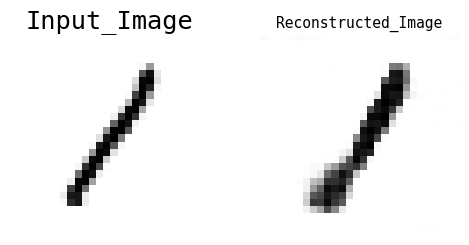

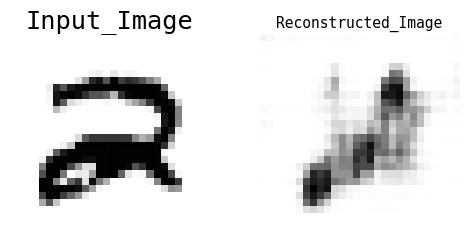

In [15]:
base_image = output_imgs[0]["x"].numpy()
anomaly_image = output_imgs[1]["x"].numpy()

recon_base_image = output_imgs[0]["x_fake"].numpy()
recon_anomaly_image = output_imgs[1]["x_fake"].numpy()

img1 = fe.util.ImgData(Input_Image=base_image, Reconstructed_Image=recon_base_image)
fig1 = img1.paint_figure()

img2 = fe.util.ImgData(Input_Image=anomaly_image, Reconstructed_Image=recon_anomaly_image)
fig2 = img2.paint_figure()

Note that the network is trained on inliers, so it's able to properly reconstruct them but does a poor job at reconstructing the outliers, thereby making it easier for discriminator to detect the outliers. 